<a href="https://colab.research.google.com/github/veronichaflasma/Machine-Learning-Expert/blob/main/Recommendation_System_Surabaya_Tourism_Destination.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Import Library**

In [72]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# **2. Data Collection**

Download Datasets from [Kaggle](https://www.kaggle.com/datasets/aprabowo/indonesia-tourism-destination)


In [2]:
# Install Kaggle package
!pip install -q Kaggle

# Upload Kaggle API
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"veronichaflasmah","key":"78adbe8d296f2d84de674ea31844965d"}'}

In [3]:
# Create directory and change the permission
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [4]:
!kaggle datasets download -d aprabowo/indonesia-tourism-destination

  0% 0.00/158k [00:00<?, ?B/s]
100% 158k/158k [00:00<00:00, 101MB/s]


In [5]:
# Unzip the dataset
!mkdir destination-datasets
!unzip indonesia-tourism-destination.zip -d destination-datasets
!ls destination-datasets

Archive:  indonesia-tourism-destination.zip
  inflating: destination-datasets/package_tourism.csv  
  inflating: destination-datasets/tourism_rating.csv  
  inflating: destination-datasets/tourism_with_id.csv  
  inflating: destination-datasets/user.csv  
package_tourism.csv  tourism_rating.csv  tourism_with_id.csv  user.csv


# **3. Data Understanding**


**This dataset consists of 4 files:**

1. `tourism_with_id.csv`: This file contains information on tourist attractions in 5 major cities in Indonesia, totaling approximately 400 entries.

2. `user.csv`: This file contains dummy user data used to create recommendation features based on user preferences.

3. `tourism_rating.csv`: This file contains three columns: user, place, and rating. It is used to develop a recommendation system based on user ratings.

4. `package_tourism.csv`: This file provides recommendations for nearby place based on factors such as time, cost, and rating.



In [6]:
# Load the Datasets
package_tourism = pd.read_csv('/content/destination-datasets/package_tourism.csv')
tourism_rating = pd.read_csv('/content/destination-datasets/tourism_rating.csv')
tourism_id = pd.read_csv('/content/destination-datasets/tourism_with_id.csv')
userid = pd.read_csv('/content/destination-datasets/user.csv')

In [7]:
# Read the Datasets
print(f'Total of tourist package: {len(package_tourism.Package.unique())}')
print(f'Total of ratings from tourists: {len(tourism_rating.User_Id.unique())}')
print(f'Total of tourist attractions: {len(tourism_id.Place_Id.unique())}')
print(f'Total of users: {len(userid.User_Id.unique())}')

Total of tourist package: 100
Total of ratings from tourists: 300
Total of tourist attractions: 437
Total of users: 300


In [8]:
package_tourism

,Package,City,Place_Tourism1,Place_Tourism2,Place_Tourism3,Place_Tourism4,Place_Tourism5
0,1,Jakarta,Pasar Tanah Abang,Taman Ayodya,Museum Tekstil,NaN,NaN
1,2,Jakarta,Pasar Tanah Abang,Pasar Taman Puring,Pasar Petak Sembilan,NaN,NaN
2,3,Jakarta,Perpustakaan Nasional,Monas,Masjid Istiqlal,NaN,NaN
3,4,Jakarta,Pulau Tidung,Pulau Bidadari,Pulau Pari,Pulau Pramuka,Pulau Pelangi
4,5,Jakarta,Museum Satria Mandala,Museum Wayang,Museum Bahari Jakarta,Museum Macan (Modern and Contemporary Art in N...,NaN
...,...,...,...,...,...,...,...
95,96,Surabaya,Ekowisata Mangrove Wonorejo,Taman Harmoni Keputih,Taman Kunang-Kunang,Taman Ekspresi Dan Perpustakaan,Museum De Javasche Bank
96,97,Surabaya,Ciputra Waterpark,Kenjeran Park,Kebun Binatang Surabaya,Food Junction Grand Pakuwon,| Atlantis Land Surabaya
97,98,Surabaya,Museum Kesehatan Dr. Adhyatma,Patung Buddha Empat Rupa,Taman Hiburan Rakyat,Taman Bungkul,Taman Flora Bratang Surabaya
98,99,Surabaya,Taman Ekspresi Dan Perpustakaan,Museum De Javasche Bank,Surabaya Museum (Gedung Siola),Museum Mpu Tantular,Taman Air Mancur Menari Kenjeran


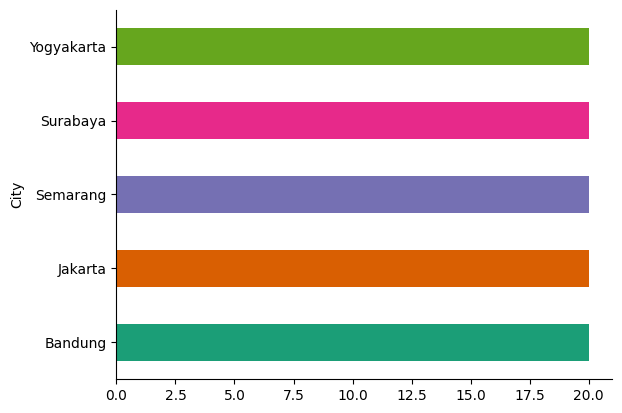

In [9]:
package_tourism.groupby('City').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [10]:
package_tourism.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Package         100 non-null    int64 
 1   City            100 non-null    object
 2   Place_Tourism1  100 non-null    object
 3   Place_Tourism2  100 non-null    object
 4   Place_Tourism3  100 non-null    object
 5   Place_Tourism4  66 non-null     object
 6   Place_Tourism5  39 non-null     object
dtypes: int64(1), object(6)
memory usage: 5.6+ KB


In [11]:
tourism_rating

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4
...,...,...,...
9995,300,425,2
9996,300,64,4
9997,300,311,3
9998,300,279,4


In [12]:
tourism_id

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,NaN,3
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156,NaN,4
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,433,Museum Mpu Tantular,Museum Negeri Mpu Tantular adalah sebuah museu...,Budaya,Surabaya,2000,4.4,45.0,"{'lat': -7.4338593, 'lng': 112.7199058}",-7.433859,112.719906,NaN,433
433,434,Taman Bungkul,Taman Bungkul adalah taman wisata kota yang te...,Taman Hiburan,Surabaya,0,4.6,NaN,"{'lat': -7.291346799999999, 'lng': 112.7398218}",-7.291347,112.739822,NaN,434
434,435,Taman Air Mancur Menari Kenjeran,Air mancur menari atau dancing fountain juga a...,Taman Hiburan,Surabaya,0,4.4,45.0,"{'lat': -7.2752955, 'lng': 112.7549381}",-7.275296,112.754938,NaN,435
435,436,Taman Flora Bratang Surabaya,Taman Flora adalah salah satu taman kota di Su...,Taman Hiburan,Surabaya,0,4.6,NaN,"{'lat': -7.294330299999999, 'lng': 112.7617534}",-7.294330,112.761753,NaN,436


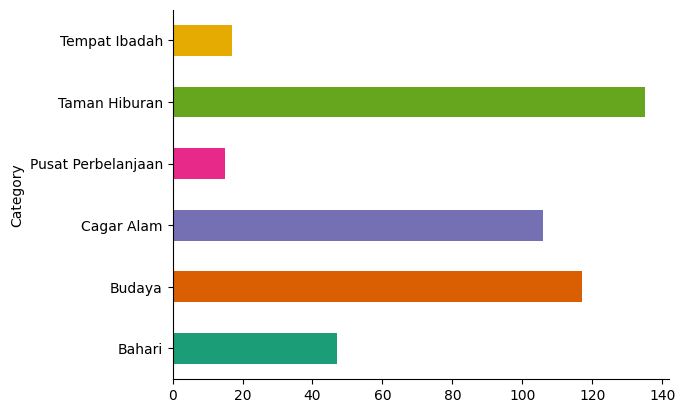

In [13]:
tourism_id.groupby('Category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [14]:
tourism_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    float64
 10  Long          437 non-null    float64
 11  Unnamed: 11   0 non-null      float64
 12  Unnamed: 12   437 non-null    int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 44.5+ KB


In [15]:
userid

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21
2,3,"Cirebon, Jawa Barat",23
3,4,"Bekasi, Jawa Barat",21
4,5,"Lampung, Sumatera Selatan",20
...,...,...,...
295,296,"Lampung, Sumatera Selatan",31
296,297,"Palembang, Sumatera Selatan",39
297,298,"Bogor, Jawa Barat",38
298,299,"Sragen, Jawa Tengah",27


# **4. Data Preparation & EDA**



In this project, only developing a recommender system for tourism destinations in the Surabaya area, so the preparation process involves selecting only the Surabaya area.

## **4.1 Data Cleaning**

### **Surabaya Tourism**

In [16]:
sby_tourism = tourism_id[tourism_id['City']=='Surabaya']
sby_tourism

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
391,392,Ekowisata Mangrove Wonorejo,Hutan Wisata Mangrove Surabaya merupakan wisat...,Cagar Alam,Surabaya,0,4.3,60.0,"{'lat': -7.308648199999999, 'lng': 112.8216622}",-7.308648,112.821662,NaN,392
392,393,Taman Harmoni Keputih,Tempat tersebut ialah Taman Hatmoni Keputih Su...,Cagar Alam,Surabaya,0,4.4,60.0,"{'lat': -7.2952211, 'lng': 112.8035603}",-7.295221,112.803560,NaN,393
393,394,Air Mancur Menari,Jembatan Kenjeran dengan air mancur menarinya ...,Taman Hiburan,Surabaya,35000,4.4,45.0,"{'lat': -7.2356933, 'lng': 112.7955234}",-7.235693,112.795523,NaN,394
394,395,Taman Prestasi,Taman Prestasi Surabaya merupakan salah satu t...,Taman Hiburan,Surabaya,0,4.6,NaN,"{'lat': -7.2614722, 'lng': 112.7428284}",-7.261472,112.742828,NaN,395
395,396,Monumen Kapal Selam,"Monumen Kapal Selam, atau disingkat Monkasel, ...",Budaya,Surabaya,15000,4.4,30.0,"{'lat': -7.2654304, 'lng': 112.7503052}",-7.265430,112.750305,NaN,396
396,397,Taman Kunang-Kunang,Taman Kunang – Kunang di Surabaya ini mempunya...,Taman Hiburan,Surabaya,0,4.4,45.0,"{'lat': -7.318220199999999, 'lng': 112.7842405}",-7.318220,112.784240,NaN,397
397,398,Taman Buah Surabaya,Wisata Taman Buah Undaan di Surabaya adalah sa...,Taman Hiburan,Surabaya,0,4.1,30.0,"{'lat': -7.266213899999999, 'lng': 112.795281}",-7.266214,112.795281,NaN,398
398,399,Taman Pelangi,Kalau pelangi biasanya ada di siang hari pasca...,Taman Hiburan,Surabaya,0,4.5,20.0,"{'lat': -7.3275604, 'lng': 112.7312242}",-7.327560,112.731224,NaN,399
399,400,Hutan Bambu Keputih,Surabaya menjadi kota metropolitan kedua setel...,Cagar Alam,Surabaya,0,4.3,25.0,"{'lat': -7.294190899999999, 'lng': 112.8017238}",-7.294191,112.801724,NaN,400
400,401,Taman Keputran,"Ntah, mengapa nama taman ini disebut dengan ta...",Taman Hiburan,Surabaya,0,4.3,NaN,"{'lat': -7.2732153, 'lng': 112.744102}",-7.273215,112.744102,NaN,401


In [17]:
sby_tourism.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46 entries, 391 to 436
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      46 non-null     int64  
 1   Place_Name    46 non-null     object 
 2   Description   46 non-null     object 
 3   Category      46 non-null     object 
 4   City          46 non-null     object 
 5   Price         46 non-null     int64  
 6   Rating        46 non-null     float64
 7   Time_Minutes  30 non-null     float64
 8   Coordinate    46 non-null     object 
 9   Lat           46 non-null     float64
 10  Long          46 non-null     float64
 11  Unnamed: 11   0 non-null      float64
 12  Unnamed: 12   46 non-null     int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 5.0+ KB


Remove columns that are not used from `sby_tourism`

In [18]:
sby_tourism = sby_tourism.drop(sby_tourism.columns[[7, 11, 12]], axis=1)

In [19]:
sby_tourism.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46 entries, 391 to 436
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Place_Id     46 non-null     int64  
 1   Place_Name   46 non-null     object 
 2   Description  46 non-null     object 
 3   Category     46 non-null     object 
 4   City         46 non-null     object 
 5   Price        46 non-null     int64  
 6   Rating       46 non-null     float64
 7   Coordinate   46 non-null     object 
 8   Lat          46 non-null     float64
 9   Long         46 non-null     float64
dtypes: float64(3), int64(2), object(5)
memory usage: 4.0+ KB


Checking for missing values in the variable `sby_tourism`

In [20]:
missing = sby_tourism.isnull().sum()
missing_val = pd.DataFrame({'Missing Values': missing})
print(missing_val)

             Missing Values
Place_Id                  0
Place_Name                0
Description               0
Category                  0
City                      0
Price                     0
Rating                    0
Coordinate                0
Lat                       0
Long                      0


### **Rating**

In [21]:
tourism_rating

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4
...,...,...,...
9995,300,425,2
9996,300,64,4
9997,300,311,3
9998,300,279,4


1. `pd.merge()`: This function is used to merge two DataFrames based on common columns or indices. It combines rows from both DataFrames where the values of the specified columns match.

2. `tourism_rating`: This DataFrame appears to contain information about user ratings for tourist place.

3. `sby_tourism[['Place_Id','Category','Place_Name','Price']]`: This part of the code is a DataFrame slice that selects specific columns ('Place_Id', 'Category', 'Place_Name', 'Price') from the DataFrame `sby_tourism`. It seems `sby_tourism` contains information about tourist place in the Surabaya area.

4. `how='right'`: This parameter specifies the type of merge to perform. In this case, it's a "right" merge, meaning that all rows from the `sby_tourism` DataFrame will be included in the result, and only the matching rows from the `tourism_rating` DataFrame will be included.

5. `on='Place_Id'`: This parameter specifies the column on which the DataFrames will be merged. Here, it's 'Place_Id', meaning that the merge will be based on the values in the 'Place_Id' column.

In [22]:
sby_package = pd.merge(tourism_rating, sby_tourism[['Place_Id','Category','Place_Name','Price']], how='right', on='Place_Id')
sby_package

,User_Id,Place_Id,Place_Ratings,Category,Place_Name,Price
0,25,392,4,Cagar Alam,Ekowisata Mangrove Wonorejo,0
1,44,392,3,Cagar Alam,Ekowisata Mangrove Wonorejo,0
2,108,392,5,Cagar Alam,Ekowisata Mangrove Wonorejo,0
3,119,392,3,Cagar Alam,Ekowisata Mangrove Wonorejo,0
4,125,392,5,Cagar Alam,Ekowisata Mangrove Wonorejo,0
...,...,...,...,...,...,...
1045,284,437,5,Tempat Ibadah,Gereja Perawan Maria Tak Berdosa Surabaya,10000
1046,288,437,1,Tempat Ibadah,Gereja Perawan Maria Tak Berdosa Surabaya,10000
1047,288,437,4,Tempat Ibadah,Gereja Perawan Maria Tak Berdosa Surabaya,10000
1048,297,437,4,Tempat Ibadah,Gereja Perawan Maria Tak Berdosa Surabaya,10000


In this stage, two dataframes are merged based on the `Place_Id` column from `sby_tourism`, using the "right join" method, and the result is stored in the variable `rating`.

In [23]:
rating = pd.merge(tourism_rating, sby_package[['Place_Id']], how='right', on='Place_Id')
rating

,User_Id,Place_Id,Place_Ratings
0,25,392,4
1,44,392,3
2,108,392,5
3,119,392,3
4,125,392,5
...,...,...,...
25151,284,437,5
25152,288,437,1
25153,288,437,4
25154,297,437,4


In [24]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25156 entries, 0 to 25155
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        25156 non-null  int64
 1   Place_Id       25156 non-null  int64
 2   Place_Ratings  25156 non-null  int64
dtypes: int64(3)
memory usage: 786.1 KB


In [25]:
missing = rating.isnull().sum()
missing_val = pd.DataFrame({'Missing Values': missing})
print(missing_val)

               Missing Values
User_Id                     0
Place_Id                    0
Place_Ratings               0


In [26]:
user = pd.merge(userid, rating[['User_Id']], how='right', on='User_Id').drop_duplicates().sort_values('User_Id')
user.head()

,User_Id,Location,Age
256,1,"Semarang, Jawa Tengah",20
7862,2,"Bekasi, Jawa Barat",21
14909,3,"Cirebon, Jawa Barat",23
7021,4,"Bekasi, Jawa Barat",21
866,5,"Lampung, Sumatera Selatan",20


In [27]:
sby_package

,User_Id,Place_Id,Place_Ratings,Category,Place_Name,Price
0,25,392,4,Cagar Alam,Ekowisata Mangrove Wonorejo,0
1,44,392,3,Cagar Alam,Ekowisata Mangrove Wonorejo,0
2,108,392,5,Cagar Alam,Ekowisata Mangrove Wonorejo,0
3,119,392,3,Cagar Alam,Ekowisata Mangrove Wonorejo,0
4,125,392,5,Cagar Alam,Ekowisata Mangrove Wonorejo,0
...,...,...,...,...,...,...
1045,284,437,5,Tempat Ibadah,Gereja Perawan Maria Tak Berdosa Surabaya,10000
1046,288,437,1,Tempat Ibadah,Gereja Perawan Maria Tak Berdosa Surabaya,10000
1047,288,437,4,Tempat Ibadah,Gereja Perawan Maria Tak Berdosa Surabaya,10000
1048,297,437,4,Tempat Ibadah,Gereja Perawan Maria Tak Berdosa Surabaya,10000


In [28]:
sby_package.isnull().sum()

User_Id          0
Place_Id         0
Place_Ratings    0
Category         0
Place_Name       0
Price            0
dtype: int64

In [31]:
total_ratings_per_place = sby_package.groupby(['Place_Name', 'User_Id'])['Place_Ratings'].sum()
# total_ratings_per_place = total_ratings_per_place.groupby('Place_Name')['Place_Ratings'].sum()

# Display as a table
print("Total Ratings per Tourist Destination:")
print(total_ratings_per_place)

Total Ratings per Tourist Destination:
Place_Name                   User_Id
Air Mancur Menari            43         2
                             65         4
                             83         1
                             97         4
                             99         3
                                       ..
Waterpark Kenjeran Surabaya  214        3
                             233        5
                             255        3
                             256        5
                             300        2
Name: Place_Ratings, Length: 998, dtype: int64


In [ ]:
duplicate = sby_package['Place_Id'].duplicated().sum()
print('Total of Duplicate Values: ', duplicate)

Total of Duplicate Values:  1004


In [33]:
destinations = sby_package.drop_duplicates('Place_Id')
destinations

,User_Id,Place_Id,Place_Ratings,Category,Place_Name,Price
0,25,392,4,Cagar Alam,Ekowisata Mangrove Wonorejo,0
16,1,393,5,Cagar Alam,Taman Harmoni Keputih,0
37,43,394,2,Taman Hiburan,Air Mancur Menari,35000
50,5,395,2,Taman Hiburan,Taman Prestasi,0
73,14,396,2,Budaya,Monumen Kapal Selam,15000
93,5,397,5,Taman Hiburan,Taman Kunang-Kunang,0
114,6,398,5,Taman Hiburan,Taman Buah Surabaya,0
142,18,399,3,Taman Hiburan,Taman Pelangi,0
159,19,400,2,Cagar Alam,Hutan Bambu Keputih,0
182,28,401,4,Taman Hiburan,Taman Keputran,0


In [34]:
duplicate = destinations['Place_Id'].duplicated().sum()
print('Total of Duplicate Values: ', duplicate)

Total of Duplicate Values:  0


In [35]:
min_rating_row = destinations.loc[destinations['Place_Ratings'].idxmin()]
max_rating_row = destinations.loc[destinations['Place_Ratings'].idxmax()]

print("Lowest rating: ", min_rating_row['Place_Name'], min_rating_row['Place_Ratings'])
print("Biggest rating: ", max_rating_row['Place_Name'], max_rating_row['Place_Ratings'])


Lowest rating:  Air Mancur Menari 2
Biggest rating:  Taman Harmoni Keputih 5


## **4.2 Univariate - Exploratory Data Analysis (EDA)**

In [36]:
destinations.describe()

,User_Id,Place_Id,Place_Ratings,Price
count,46.000000,46.000000,46.000000,46.000000
mean,14.673913,414.500000,3.521739,10195.652174
std,12.925521,13.422618,1.069561,24540.777462
min,1.000000,392.000000,2.000000,0.000000
25%,5.000000,403.250000,3.000000,0.000000
50%,11.500000,414.500000,4.000000,0.000000
75%,20.000000,425.750000,4.000000,8750.000000
max,55.000000,437.000000,5.000000,125000.000000


In [37]:
destinations.head()

,User_Id,Place_Id,Place_Ratings,Category,Place_Name,Price
0,25,392,4,Cagar Alam,Ekowisata Mangrove Wonorejo,0
16,1,393,5,Cagar Alam,Taman Harmoni Keputih,0
37,43,394,2,Taman Hiburan,Air Mancur Menari,35000
50,5,395,2,Taman Hiburan,Taman Prestasi,0
73,14,396,2,Budaya,Monumen Kapal Selam,15000


In [38]:
destinations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46 entries, 0 to 1012
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   User_Id        46 non-null     int64 
 1   Place_Id       46 non-null     int64 
 2   Place_Ratings  46 non-null     int64 
 3   Category       46 non-null     object
 4   Place_Name     46 non-null     object
 5   Price          46 non-null     int64 
dtypes: int64(4), object(2)
memory usage: 3.6+ KB


In [39]:
destinations.shape

(46, 6)

In [40]:
def visualize_cat(data, target_encoding='Category', figsize=(10, 3), palette='viridis'):
    sns.set_style('whitegrid')
    plt.figure(figsize=figsize)

    rel_freq = data[target_encoding].value_counts(normalize=True, ascending=False) * 100

    ax = sns.barplot(x=rel_freq.values, y=rel_freq.index, palette=palette)

    for i in range(rel_freq.shape[0]):
        ax.text(rel_freq.values[i] + 0.5, i, str(round(rel_freq.values[i], 1)) + '%',
                ha='left', va='center', color='black', fontsize=10)

    total_count = len(data)
    class_counts = data[target_encoding].value_counts()

    class_info = ', '.join([f'{class_name}: {class_count}' for class_name, class_count in class_counts.items()])
    plt.text(0, -1, f'Total of Tourism place in Surabaya: {total_count}\n{class_info}\n', ha='left', va='center', fontsize=12)

    plt.xlabel('Relative Frequency (%)', fontsize=14)
    plt.ylabel(target_encoding.replace('_', ' ').title(), fontsize=14)
    plt.tight_layout()
    plt.show()

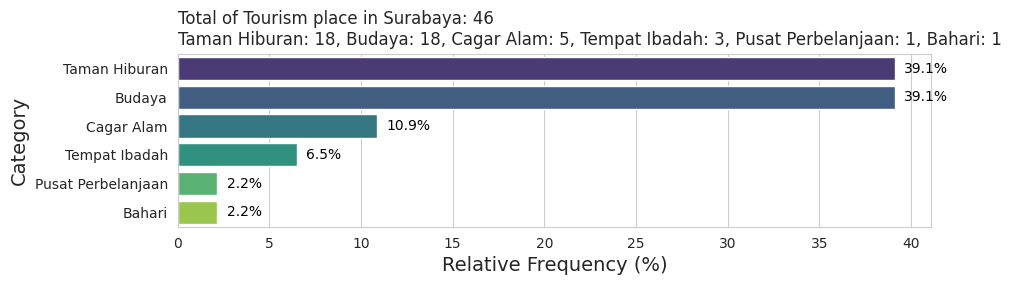

In [41]:
visualize_cat(destinations)

In [42]:
df = pd.DataFrame(destinations)
total_rating = df.groupby('Place_Name')['Place_Ratings'].sum()
print(total_rating)

Place_Name
Air Mancur Menari                            2
Atlantis Land Surabaya                       3
Balai Kota Surabaya                          4
Ciputra Waterpark                            2
Ekowisata Mangrove Wonorejo                  4
Food Junction Grand Pakuwon                  3
Gereja Perawan Maria Tak Berdosa Surabaya    5
House of Sampoerna                           3
Hutan Bambu Keputih                          2
Jembatan Merah                               5
Kebun Bibit Wonorejo                         3
Kebun Binatang Surabaya                      2
Kenjeran Park                                2
Keraton Surabaya                             4
Klenteng Sanggar Agung                       4
Masjid Muhammad Cheng Hoo                    4
Masjid Nasional Al-Akbar                     2
Monumen Bambu Runcing Surabaya               3
Monumen Jalesveva Jayamahe                   4
Monumen Kapal Selam                          2
Monumen Tugu Pahlawan                        2
Mu

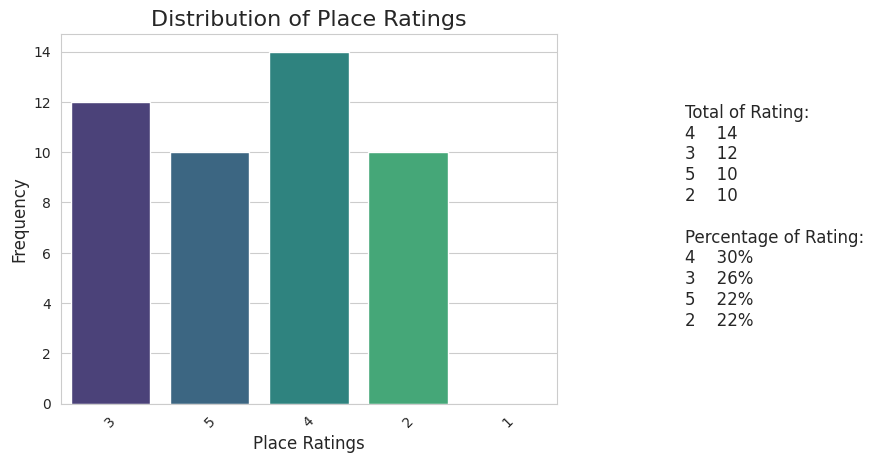

In [43]:
count = destinations['Place_Ratings'].value_counts()
percent = 100 * destinations['Place_Ratings'].value_counts(normalize=True)

ax = sns.countplot(x=destinations['Place_Ratings'], data=rating, palette='viridis', order=rating['Place_Ratings'].value_counts().index)

plt.title('Distribution of Place Ratings', fontsize=16)
plt.xlabel('Place Ratings', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)

count_str = count.to_string()
percent_str = percent.apply(lambda x: f"{x:.0f}%").to_string()

plt.figtext(1.1, 0.5, f"Total of Rating:\n{count_str}\n\nPercentage of Rating:\n{percent_str}", ha="left", va="center", fontsize=12)
plt.show()


## **4.3 Multivariate - Exploratory Data Analysis (EDA)**

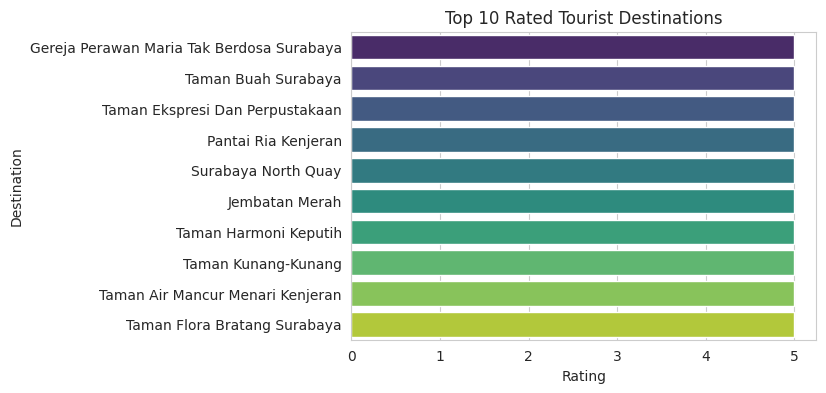

In [44]:
top_destinations = destinations.sort_values(by='Place_Ratings', ascending=False).head(10)

plt.figure(figsize=(6, 4))
sns.barplot(x='Place_Ratings', y='Place_Name', data=top_destinations, palette='viridis')
plt.title('Top 10 Rated Tourist Destinations')
plt.xlabel('Rating')
plt.ylabel('Destination')
plt.show()

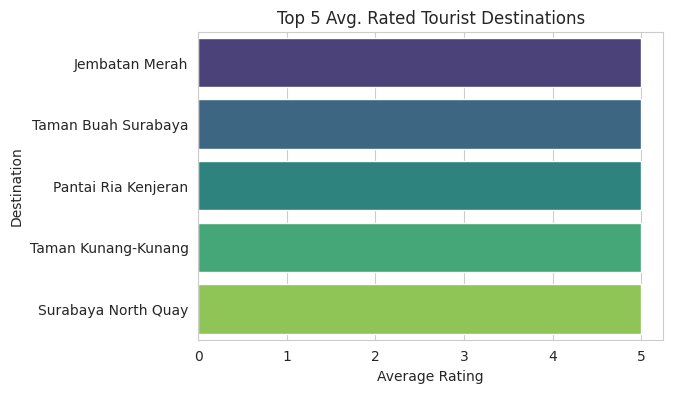

Summary Review for Top-Rated Tourist Destinations:
             Place_Name  Total  Average_Rating
9        Jembatan Merah      1             5.0
34  Taman Buah Surabaya      1             5.0
26  Pantai Ria Kenjeran      1             5.0
41  Taman Kunang-Kunang      1             5.0
31  Surabaya North Quay      1             5.0


In [45]:
# Calculate average rating and total number of reviews for each destination
summary_review = destinations.groupby('Place_Name')['Place_Ratings'].agg(['count', 'mean']).reset_index()
summary_review.columns = ['Place_Name', 'Total', 'Average_Rating']

# Sort the DataFrame by average rating in descending order and select the top 5 destinations
top_5_destinations = summary_review.sort_values(by='Average_Rating', ascending=False).head(5)

# Plotting
plt.figure(figsize=(6, 4))
sns.barplot(x='Average_Rating', y='Place_Name', data=top_5_destinations, palette='viridis')
plt.title('Top 5 Avg. Rated Tourist Destinations')
plt.xlabel('Average Rating')
plt.ylabel('Destination')
plt.show()

# Summary review
print("Summary Review for Top-Rated Tourist Destinations:")
top_5_destinations['Average_Rating'] = top_5_destinations['Average_Rating'].round(2)
print(top_5_destinations)


This step is create a bar plot to visualize the top 5 tourist destinations in Surabaya with the highest entry ticket prices.

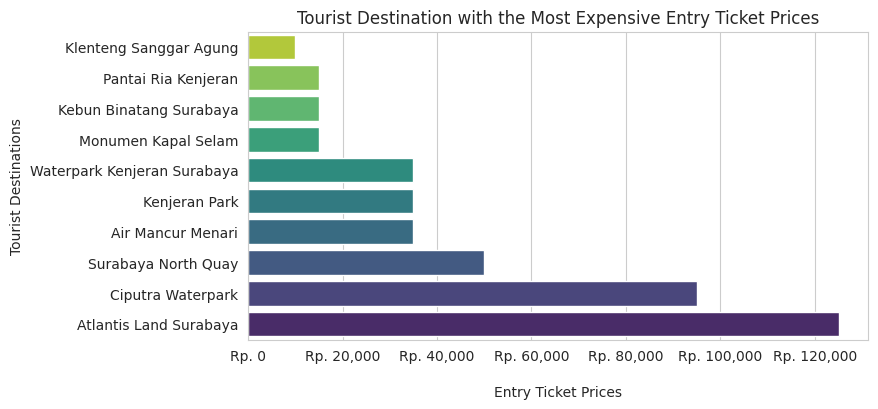

Top 5 Tourist Destinations in Surabaya with the Highest Entry Ticket Prices:
                                     Place_Name   Price
854                      Atlantis Land Surabaya  125000
398                           Ciputra Waterpark   95000
278                         Surabaya North Quay   50000
37                            Air Mancur Menari   35000
734                 Waterpark Kenjeran Surabaya   35000
258                               Kenjeran Park   35000
360                     Kebun Binatang Surabaya   15000
73                          Monumen Kapal Selam   15000
708                         Pantai Ria Kenjeran   15000
1012  Gereja Perawan Maria Tak Berdosa Surabaya   10000


In [48]:
# Creating DataFrame
price = pd.DataFrame(destinations)
highest_price = price[['Place_Name', 'Category', 'Price']]

# Selecting top 10 highest priced destinations
priced = highest_price.nlargest(10, 'Price')

# Rupiah (Rp.) currency format
def rupiah_formatter(x, pos):
    return f'Rp. {x:,.0f}'

plt.figure(figsize=(8, 4))
sns.barplot(x='Price', y='Place_Name', data=priced, palette='viridis')  # Use 'priced' DataFrame for plotting
plt.xlabel('\nEntry Ticket Prices')
plt.ylabel('Tourist Destinations')
plt.title('Tourist Destination with the Most Expensive Entry Ticket Prices')
plt.gca().invert_yaxis()
plt.gca().xaxis.set_major_formatter(FuncFormatter(rupiah_formatter))  # Apply Rp. currency format to x-axis
plt.show()

highest_price = destinations.sort_values(by='Price', ascending=False).head(10)

# Display the top 5 destinations with the highest entry ticket prices
print("Top 5 Tourist Destinations in Surabaya with the Highest Entry Ticket Prices:")
print(highest_price[['Place_Name', 'Price']])

# **5. Modelling**

## **5.1 Content Based Filtering**

### **TF-IDF Vectorizer**




TF-IDF vectorization is to analyze the text data in the 'Place_Name' column of the `sby_tourism` DataFrame and then retrieves the unique terms as feature names.

In [49]:
tf = TfidfVectorizer()
tf.fit(destinations['Place_Name'])
tf.get_feature_names_out()

array(['adhyatma', 'agung', 'air', 'akbar', 'al', 'atlantis', 'balai',
       'bambu', 'bank', 'barunawati', 'batik', 'berdosa', 'bibit',
       'binatang', 'bratang', 'buah', 'buaya', 'buddha', 'bungkul',
       'cheng', 'ciputra', 'crana', 'dan', 'de', 'dr', 'ekowisata',
       'ekspresi', 'empat', 'flora', 'food', 'gedung', 'gereja', 'grand',
       'harmoni', 'hiburan', 'hoo', 'house', 'hutan', 'jala', 'jalesveva',
       'javasche', 'jayamahe', 'jembatan', 'junction', 'kapal', 'kebun',
       'kenjeran', 'keputih', 'keputran', 'keraton', 'kesehatan',
       'klenteng', 'kota', 'kunang', 'land', 'loka', 'mancur', 'mangrove',
       'maria', 'masjid', 'menari', 'merah', 'monumen', 'mpu', 'muhammad',
       'mundu', 'museum', 'nasional', 'nopember', 'north', 'of',
       'pahlawan', 'pakuwon', 'pantai', 'park', 'patung', 'pelangi',
       'perawan', 'perpustakaan', 'prestasi', 'quay', 'rakyat', 'ria',
       'rumah', 'runcing', 'rupa', 'sampoerna', 'sanggar', 'selam',
       'sepuluh

In [50]:
# Change the data into matrix integer
tfdif_matrix = tf.fit_transform(destinations['Place_Name'])
tfdif_matrix.shape

(46, 100)

In [51]:
# Change tf id into matrix format
tfdif_matrix.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.53793913],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.57735027, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.49425167, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [52]:
pd.DataFrame(
    tfdif_matrix.todense(),
    columns = tf.get_feature_names_out(),
    index = destinations.Category
).sample(22, axis = 1).sample(10, axis = 0)

,land,crana,klenteng,bratang,kesehatan,masjid,north,monumen,ekowisata,grand,...,buddha,buah,quay,keputran,siola,akbar,waterpark,berdosa,kunang,museum
Category,,,,,,,,,,,,,,,,,,,,,
Cagar Alam,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
Taman Hiburan,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
Budaya,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.374074
Taman Hiburan,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
Tempat Ibadah,0.0,0.0,0.0,0.000000,0.0,0.473743,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.524945,0.0,0.0,0.0,0.000000
Taman Hiburan,0.0,0.0,0.0,0.621957,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
Taman Hiburan,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
Budaya,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.598653,0.000000,0.0,0.0,0.0,0.418242
Taman Hiburan,0.0,0.0,0.0,0.000000,0.0,0.000000,0.659066,0.0,0.0,0.0,...,0.0,0.0,0.659066,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000


### **Consine similarity**

The resulting cosine_sim matrix contains pairwise cosine similarity scores between all items (or documents) in the dataset.

In [53]:
cosine_sim = cosine_similarity(tfdif_matrix)
cosine_sim

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.10698834, 0.12150046,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.85606901, 0.        ,
        0.        ],
       ...,
       [0.        , 0.10698834, 0.85606901, ..., 1.        , 0.09636795,
        0.        ],
       [0.        , 0.12150046, 0.        , ..., 0.09636795, 1.        ,
        0.08162448],
       [0.        , 0.        , 0.        , ..., 0.        , 0.08162448,
        1.        ]])

In [54]:
cosine_sim_df = pd.DataFrame(cosine_sim, index = destinations['Place_Name'], columns = destinations['Place_Name'])
print('Shape : ', cosine_sim_df.shape)

cosine_sim_df.sample(5, axis = 1).sample(10, axis = 0)

Shape :  (46, 46)


Place_Name,Taman Harmoni Keputih,Taman Bungkul,Air Mancur Menari,Monumen Bambu Runcing Surabaya,Taman Air Mancur Menari Kenjeran
Place_Name,,,,,
Atlantis Land Surabaya,0.000000,0.000000,0.000000,0.120665,0.000000
Pantai Ria Kenjeran,0.000000,0.000000,0.000000,0.000000,0.206114
Kebun Binatang Surabaya,0.000000,0.000000,0.000000,0.125844,0.000000
Museum De Javasche Bank,0.000000,0.000000,0.000000,0.000000,0.000000
Taman Air Mancur Menari Kenjeran,0.106988,0.136796,0.856069,0.000000,1.000000
Hutan Bambu Keputih,0.346847,0.000000,0.000000,0.304326,0.000000
Surabaya Museum (Gedung Siola),0.000000,0.000000,0.000000,0.109605,0.000000
Jembatan Merah,0.000000,0.000000,0.000000,0.000000,0.000000
Taman Mundu,0.172472,0.220524,0.000000,0.000000,0.136796


### Recommendation Function

In [55]:
def recommendation(place, similarity_data = cosine_sim_df, items = destinations[['Place_Name', 'Category','Price']], k = 5) :
  index = similarity_data.loc[:, place].to_numpy().argpartition(
      range(-1, -k, -1)
  )

  closest = similarity_data.columns[index[-1:-(k+2):-1]]
  closest = closest.drop(place, errors = 'ignore')

  return pd.DataFrame(closest).merge(items).head(k)

In [56]:
destinations[destinations.Place_Name.eq('Taman Prestasi')]

,User_Id,Place_Id,Place_Ratings,Category,Place_Name,Price
50,5,395,2,Taman Hiburan,Taman Prestasi,0


In [57]:
recommendation('Taman Prestasi')

,Place_Name,Category,Price
0,Taman Pelangi,Taman Hiburan,0
1,Taman Barunawati,Taman Hiburan,0
2,Taman Mundu,Taman Hiburan,0
3,Taman Keputran,Taman Hiburan,0
4,Taman Air Mancur Menari Kenjeran,Taman Hiburan,0


## **5.2 Collaborative Filtering**

In [58]:
dt = destinations
dt.head()

,User_Id,Place_Id,Place_Ratings,Category,Place_Name,Price
0,25,392,4,Cagar Alam,Ekowisata Mangrove Wonorejo,0
16,1,393,5,Cagar Alam,Taman Harmoni Keputih,0
37,43,394,2,Taman Hiburan,Air Mancur Menari,35000
50,5,395,2,Taman Hiburan,Taman Prestasi,0
73,14,396,2,Budaya,Monumen Kapal Selam,15000


In [59]:
# Convert User_Id to a list without the same values
user_ids = dt['User_Id'].unique().tolist()
print('list User_Id: ', user_ids)

# Performing encoding of User_Id
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded User_Id : ', user_to_user_encoded)

# Performing the process of encoding numbers to User_Id
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke User_Id: ', user_encoded_to_user)

list User_Id:  [25, 1, 43, 5, 14, 6, 18, 19, 28, 9, 20, 4, 2, 27, 21, 16, 55, 3, 13, 44, 12, 11, 30]
encoded User_Id :  {25: 0, 1: 1, 43: 2, 5: 3, 14: 4, 6: 5, 18: 6, 19: 7, 28: 8, 9: 9, 20: 10, 4: 11, 2: 12, 27: 13, 21: 14, 16: 15, 55: 16, 3: 17, 13: 18, 44: 19, 12: 20, 11: 21, 30: 22}
encoded angka ke User_Id:  {0: 25, 1: 1, 2: 43, 3: 5, 4: 14, 5: 6, 6: 18, 7: 19, 8: 28, 9: 9, 10: 20, 11: 4, 12: 2, 13: 27, 14: 21, 15: 16, 16: 55, 17: 3, 18: 13, 19: 44, 20: 12, 21: 11, 22: 30}


In [60]:
# Mengubah Place_Id menjadi list tanpa nilai yang sama
place_ids = dt['Place_Id'].unique().tolist()

# Melakukan proses encoding Place_Id
place_to_place_encoded = {x: i for i, x in enumerate(place_ids)}

# Melakukan proses encoding angka ke Place_Id
place_encoded_to_place = {i: x for i, x in enumerate(place_ids)}

In [61]:
# Mapping User_Id ke dataframe user
dt['user'] = dt['User_Id'].map(user_to_user_encoded)

# Mapping Place_Id ke dataframe place
dt['place'] = dt['Place_Id'].map(place_to_place_encoded)

In [62]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)

# Mendapatkan jumlah place
num_place = len(place_encoded_to_place)
print(num_place)

# Mengubah rating menjadi nilai float
dt['Place_Ratings'] = dt['Place_Ratings'].values.astype(np.float32)

# Nilai minimum rating
min_rating = min(dt['Place_Ratings'])

# Nilai maksimal rating
max_rating = max(dt['Place_Ratings'])

print('Number of User: {}, Number of place: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_place, min_rating, max_rating
))

23
46
Number of User: 23, Number of place: 46, Min Rating: 2.0, Max Rating: 5.0


### **5.2.1 Training**

In [63]:

dt = dt.sample(frac=1, random_state=42)
dt.head()

,User_Id,Place_Id,Place_Ratings,Category,Place_Name,Price,user,place
886,30,431,4.0,Taman Hiburan,Taman Hiburan Rakyat,5000,22,39
551,9,417,4.0,Budaya,Klenteng Sanggar Agung,10000,9,25
577,19,418,4.0,Budaya,Museum Sepuluh Nopember Kota Surabaya,5000,7,26
990,5,436,5.0,Taman Hiburan,Taman Flora Bratang Surabaya,0,3,44
781,21,427,4.0,Budaya,Patung Buddha Empat Rupa,0,14,35


In [65]:
x = dt[['user', 'place']].values

y = dt['Place_Ratings'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

train_indices = int(0.8 * dt.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

# tf.convert_to_tensor(x_train, dtype=tf.float32)

print(x, y)

[[22 39]
 [ 9 25]
 [ 7 26]
 [ 3 44]
 [14 35]
 [ 3 41]
 [ 4  4]
 [10 12]
 [ 7  8]
 [ 3  3]
 [ 5  6]
 [ 9 24]
 [19 32]
 [14 19]
 [11 17]
 [ 1 13]
 [ 4 43]
 [12 15]
 [ 8  9]
 [13 16]
 [20 37]
 [ 0 31]
 [16 27]
 [ 0  0]
 [18 30]
 [17 29]
 [ 3  5]
 [ 9 11]
 [10 33]
 [ 1  1]
 [ 7 40]
 [12 21]
 [ 2  2]
 [12 34]
 [ 2 23]
 [ 1 36]
 [ 9 10]
 [15 22]
 [ 5 18]
 [12 45]
 [ 6 20]
 [ 6  7]
 [ 3 42]
 [11 14]
 [ 3 28]
 [21 38]] [0.66666667 0.66666667 0.66666667 1.         0.66666667 0.66666667
 0.         0.         0.         0.         1.         0.66666667
 1.         0.66666667 0.33333333 1.         1.         1.
 0.66666667 0.         0.33333333 0.33333333 0.         0.66666667
 0.66666667 0.33333333 1.         0.33333333 0.66666667 1.
 0.66666667 0.33333333 0.         0.66666667 0.         0.33333333
 0.33333333 1.         0.         1.         0.         0.33333333
 0.66666667 0.33333333 0.33333333 0.33333333]


In [73]:
class RecommenderNet(keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_place, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_place = num_place
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.place_embedding = layers.Embedding( # layer embeddings place
        num_place,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.place_bias = layers.Embedding(num_place, 1) # layer embedding place bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    place_vector = self.place_embedding(inputs[:, 1]) # memanggil layer embedding 3
    place_bias = self.place_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_place = tf.tensordot(user_vector, place_vector, 2)

    x = dot_user_place + user_bias + place_bias

    return tf.nn.sigmoid(x) # activation sigmoid

In [74]:
model = RecommenderNet(num_users, num_place, 50) # inisialisasi model

model.compile(
    loss = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[keras.metrics.RootMeanSquaredError()]
)

In [75]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 100,
    validation_data = (x_val, y_val)
)

Epoch 1/100
5/5 [==============================] - 1s 84ms/step - loss: 0.7311 - root_mean_squared_error: 0.3710 - val_loss: 0.7689 - val_root_mean_squared_error: 0.3914
Epoch 2/100
5/5 [==============================] - 0s 16ms/step - loss: 1.0974 - root_mean_squared_error: 0.4941 - val_loss: 0.7684 - val_root_mean_squared_error: 0.3911
Epoch 3/100
5/5 [==============================] - 0s 11ms/step - loss: 1.0307 - root_mean_squared_error: 0.4999 - val_loss: 0.7692 - val_root_mean_squared_error: 0.3916
Epoch 4/100
5/5 [==============================] - 0s 15ms/step - loss: 0.7824 - root_mean_squared_error: 0.4074 - val_loss: 0.7713 - val_root_mean_squared_error: 0.3928
Epoch 5/100
5/5 [==============================] - 0s 15ms/step - loss: 0.9182 - root_mean_squared_error: 0.4274 - val_loss: 0.7725 - val_root_mean_squared_error: 0.3936
Epoch 6/100
5/5 [==============================] - 0s 15ms/step - loss: 0.7897 - root_mean_squared_error: 0.3834 - val_loss: 0.7735 - val_root_mean_sq

### **5.2.2 Evaluation**

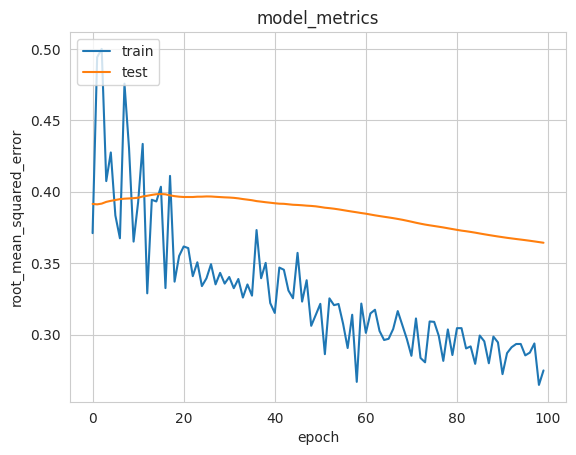

In [76]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [85]:
place_dt = destinations
df = pd.read_csv('/content/destination-datasets/tourism_rating.csv')

df['Place_Ratings'] = df['Place_Ratings'].values.astype(np.float32)

user_id = dt.User_Id.sample(1).iloc[0]
place_visited_by_user = df[df.User_Id == user_id]

place_not_visited = place_dt[~place_dt['Place_Id'].isin(place_visited_by_user.Place_Id.values)]['Place_Id']
place_not_visited = list(
    set(place_not_visited)
    .intersection(set(place_to_place_encoded.keys()))
)

place_not_visited = [[place_to_place_encoded.get(x)] for x in place_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_place_array = np.hstack(
    ([[user_encoder]] * len(place_not_visited), place_not_visited)
)

In [87]:
ratings = model.predict(user_place_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_place_ids = [
    place_encoded_to_place.get(place_not_visited[x][0]) for x in top_ratings_indices
]

print('Showing recommendations for users : {}'.format(user_id))
print('===' * 9)
print('Place with high ratings from user')
print('----' * 8)

top_place_user = (
    place_visited_by_user.sort_values(
        by = 'Place_Ratings',
        ascending=False
    )
    .head(5)
    .Place_Id.values
)

place_df_rows = place_dt[place_dt['Place_Id'].isin(top_place_user)]
for row in place_df_rows.itertuples():
  print(row.Place_Name, ':', row.Category)

print('----' * 8)
print('Top 10 place recommendation')
print('----' * 8)

recommended_place = place_dt[place_dt['Place_Id'].isin(recommended_place_ids)]
for row in recommended_place.itertuples():
  print(row.Place_Name, ':', row.Category)

2/2 [==============================] - 0s 6ms/step
Showing recommendations for users : 1
Place with high ratings from user
--------------------------------
Taman Harmoni Keputih : Cagar Alam
Surabaya North Quay : Taman Hiburan
--------------------------------
Top 10 place recommendation
--------------------------------
Balai Kota Surabaya : Budaya
Patung Buddha Empat Rupa : Budaya
Atlantis Land Surabaya : Taman Hiburan
Taman Hiburan Rakyat : Taman Hiburan
Taman Mundu : Taman Hiburan
Museum Mpu Tantular : Budaya
Taman Bungkul : Taman Hiburan
Taman Air Mancur Menari Kenjeran : Taman Hiburan
Taman Flora Bratang Surabaya : Taman Hiburan
Gereja Perawan Maria Tak Berdosa Surabaya : Tempat Ibadah
